# Module 2 — 2.7(B): Hands-On — Auto MPG Regression

**Goal:** End-to-end regression on a realistic (synthetic) Auto MPG dataset with *intentional messiness*.

**Steps**
1) Generate & inspect
2) Clean & prepare 
3) Train/Test Split 
4) OLS baseline  
5) Polynomial (deg 2/3)  
6) Ridge/Lasso/ElasticNet  
7) Metrics (RMSE/MAE/R²/MAPE)  
8) GridSearchCV  
9) Reflection


## 0) Database Set-up

In [1]:
import numpy as np
import pandas as pd

def make_auto_mpg_realistic(n=600, seed=1955, noise=1.5):
    rng = np.random.default_rng(seed)
    cyl = rng.choice([3,4,5,6,8], size=n, p=[0.05,0.45,0.05,0.30,0.15])
    disp= np.clip(rng.normal(150,60,n) + (cyl-4)*30, 60, 450)
    hp  = np.clip(rng.normal(100,35,n) + (cyl-4)*10, 40, 220)
    wt  = np.clip(rng.normal(3000,600,n) + (cyl-4)*200, 1500, 5500)
    acc = np.clip(rng.normal(15,2.5,n) - (cyl-4)*0.4, 8, 25)
    yr  = rng.integers(70,83,n)
    org = rng.choice(['USA','EU','JP'], size=n, p=[0.55,0.25,0.20])
    mpg = (45 - 0.006*wt - 0.03*hp + 0.15*acc + 0.5*(yr-70) + (org=='JP')*2.0 + (org=='EU')*1.0 + rng.normal(0,noise,n))
    df = pd.DataFrame({'cylinders':cyl,'displacement':disp.round(1),'horsepower':hp.round(0),
                       'weight':wt.round(0),'acceleration':acc.round(1),'model_year':yr,'origin':org,'mpg':mpg.round(1)})
    # messiness
    rng = np.random.default_rng(seed+1)
    df.loc[rng.random(n)<0.07,'horsepower']=np.nan
    df.loc[rng.random(n)<0.05,'origin']=None
    bad = df.sample(3, random_state=seed+2).index
    df.loc[bad,'weight']=[0,-100,12000]
    df.loc[df.sample(2, random_state=seed+3).index,'mpg']=[1.0,120.0]
    return df


## 1) Generate & inspect

In [2]:
# --- 1) Generate & inspect ---
df = make_auto_mpg_realistic()
df.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,4,190.8,153.0,2926.0,15.0,73,EU,28.5
1,6,261.2,128.0,2732.0,14.5,79,USA,31.2
2,6,216.6,98.0,4728.0,12.4,78,USA,22.5
3,8,250.4,147.0,4967.0,18.6,82,USA,19.5
4,4,219.6,70.0,2188.0,11.5,80,USA,34.7


**Sanity-check**: columns, types, missing values (`horsepower`, `origin`), and invalid `weight`.

In [3]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     600 non-null    int64  
 1   displacement  600 non-null    float64
 2   horsepower    553 non-null    float64
 3   weight        600 non-null    float64
 4   acceleration  600 non-null    float64
 5   model_year    600 non-null    int64  
 6   origin        568 non-null    object 
 7   mpg           600 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 37.6+ KB


,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
count,600.000000,600.000000,553.000000,600.000000,600.000000,600.000000,568,600.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,USA,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,306,NaN
mean,5.216667,189.763833,112.895118,3289.875000,14.591833,76.185000,NaN,27.952500
std,1.501159,72.344757,37.128350,769.068054,2.610934,3.755122,NaN,6.356868
min,3.000000,60.000000,40.000000,-100.000000,8.000000,70.000000,NaN,1.000000
25%,4.000000,139.500000,88.000000,2854.250000,12.775000,73.000000,NaN,24.400000
50%,5.000000,186.250000,112.000000,3276.000000,14.600000,76.000000,NaN,27.950000
75%,6.000000,239.150000,137.000000,3715.750000,16.400000,79.250000,NaN,31.200000


## 2) Clean & prepare

We will clean, impute, and encode next.

In [5]:
# --- 2) Clean & Prepare ---

#import numpy as np
#import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Drop rows with missing target values (mpg)
# A regression model cannot train without its label.
df = df.dropna(subset=['mpg']).copy()

# Replace invalid values with NaN so they can be imputed
# Weight cannot be zero or negative → treat as missing.
df.loc[df['weight'] <= 0, 'weight'] = np.nan

# Identify numeric and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Build preprocessing pipelines
# Numeric: median imputation + scaling
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# Categorical: most frequent imputation + one-hot encoding
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps into a ColumnTransformer
pre = ColumnTransformer([
    ('num', num_pipe, [c for c in num_cols if c != 'mpg']),  # exclude target
    ('cat', cat_pipe, cat_cols)
])

# Preview the cleaned data (before splitting)
df.head()


,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,4,190.8,153.0,2926.0,15.0,73,EU,28.5
1,6,261.2,128.0,2732.0,14.5,79,USA,31.2
2,6,216.6,98.0,4728.0,12.4,78,USA,22.5
3,8,250.4,147.0,4967.0,18.6,82,USA,19.5
4,4,219.6,70.0,2188.0,11.5,80,USA,34.7


In [6]:
# Optional: Confirm no missing values remain after cleaning
df.isna().sum()

cylinders        0
displacement     0
horsepower      47
weight           2
acceleration     0
model_year       0
origin          32
mpg              0
dtype: int64

**Preprocessing**: impute numerics (median), impute/encode categorical, scale numerics; then split train/test.

## 3) Train/Test Split 

In [7]:
# --- 3) Train/Test Split ---

from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('mpg', axis=1)
y = df['mpg']

# 80/20 split, using consistent seed for reproducibility
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=1955)

# Show the resulting shapes
(Xtr.shape, Xte.shape), (len(ytr), len(yte))


(((480, 7), (120, 7)), (480, 120))

Hold out ~20% for an unbiased evaluation of generalization.

## 4) OLS baseline

In [10]:
# --- 4) OLS Baseline Model ---

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# OLS pipeline: preprocessing + linear regression
ols = Pipeline([
    ('pre', pre),
    ('model', LinearRegression())
])

# Fit on training data
ols.fit(Xtr, ytr)

# Predict on test set
yhat_ols = ols.predict(Xte)

# MAPE helper
def mape(y_true, y_pred, eps=1e-9):
    yt = np.asarray(y_true, float)
    yp = np.asarray(y_pred, float)
    m  = np.abs(yt) > eps
    return np.mean(np.abs((yt[m] - yp[m]) / (yt[m] + eps))) * 100 if m.any() else np.nan


# Report metrics
print(
    "OLS → RMSE: %.2f | MAE: %.2f | R²: %.3f | MAPE: %.2f%%"
    (
        np.sqrt(mean_squared_error(yte, yhat_ols)),
        mean_absolute_error(yte, yhat_ols),
        r2_score(yte, yhat_ols),
        mape(yte, yhat_ols)
    )
)

OLS → RMSE: 2.03 | MAE: 1.63 | R²: 0.799 | MAPE: 6.10%


In [12]:
# --- Extract OLS coefficients with feature names ---

# 1) Get the preprocessing transformer
preprocess = ols.named_steps['pre']

# 2) Get the model
lin = ols.named_steps['model']

# 3) Extract the transformed feature names
num_features = [c for c in num_cols if c != 'mpg']
cat_features = preprocess.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)

feature_names = np.concatenate([
    num_features,
    cat_features
])

# 4) Create a coefficient table
coef_table = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lin.coef_
}).sort_values("Coefficient", ascending=False)

coef_table


,Feature,Coefficient
7,origin_JP,1.904865
5,model_year,1.733741
4,acceleration,0.200986
1,displacement,-0.018569
6,origin_EU,-0.288382
9,origin_None,-0.675225
0,cylinders,-0.867834
8,origin_USA,-0.941259
2,horsepower,-1.263274
3,weight,-3.028482


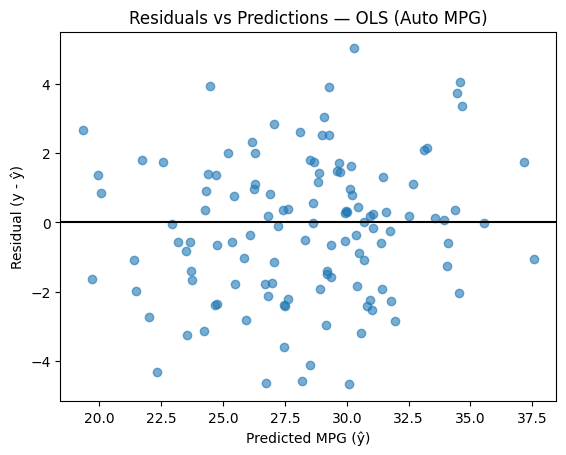

In [11]:
# Optional: residual plot for OLS
resid = yte - yhat_ols

plt.scatter(yhat_ols, resid, alpha=0.6)
plt.axhline(0, color='k')
plt.xlabel("Predicted MPG (ŷ)")
plt.ylabel("Residual (y - ŷ)")
plt.title("Residuals vs Predictions — OLS (Auto MPG)")
plt.show()


Baseline linear model with preprocessing pipeline.

## 5) Polynomial (deg 2/3) 

In [22]:
# --- 5) Polynomial Regression (degree 2) ---

from sklearn.preprocessing import PolynomialFeatures

# Apply polynomial expansion to numeric columns only
poly_num = ColumnTransformer([
    ('num_poly', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scale', StandardScaler())
    ]), [c for c in num_cols if c != 'mpg']),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

# Final degree-2 pipeline
poly2 = Pipeline([
    ('pre', poly_num),
    ('model', LinearRegression())
])

poly2.fit(Xtr, ytr)
yhat_p2 = poly2.predict(Xte)

print(
    "Poly2 → RMSE: %.2f | MAE: %.2f | R²: %.3f | MAPE: %.2f%%" %
     (
        np.sqrt(mean_squared_error(yte, yhat_p2)),
        mean_absolute_error(yte, yhat_p2),
        r2_score(yte, yhat_p2),
        mape(yte, yhat_p2)
    )
)

# --- Polynomial Regression (degree 3) ---

poly_num3 = ColumnTransformer([
    ('num_poly', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('scale', StandardScaler())
    ]), [c for c in num_cols if c != 'mpg']),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

poly3 = Pipeline([
    ('pre', poly_num3),
    ('model', LinearRegression())
])

poly3.fit(Xtr, ytr)
yhat_p3 = poly3.predict(Xte)

print(
    "Poly3 → RMSE: %.2f | MAE: %.2f | R²: %.3f | MAPE: %.2f%%" %
    (
        np.sqrt(mean_squared_error(yte, yhat_p3)),
        mean_absolute_error(yte, yhat_p3),
        r2_score(yte, yhat_p3),
        mape(yte, yhat_p3)
    )
)


Poly2 → RMSE: 1.91 | MAE: 1.49 | R²: 0.822 | MAPE: 5.38%
Poly3 → RMSE: 3.32 | MAE: 2.25 | R²: 0.460 | MAPE: 8.12%


Polynomial expansion on numerics; categoricals are one-hot encoded and included linearly.

## 6) Ridge/Lasso/ElasticNet  

In [23]:
# --- Step 6) Regularized Regression: Ridge, Lasso, ElasticNet ---

from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Regularized models using the same preprocessing pipeline (pre)
ridge = Pipeline([
    ('pre', pre),
    ('model', Ridge(alpha=1.0, random_state=1955))
])

lasso = Pipeline([
    ('pre', pre),
    ('model', Lasso(alpha=0.1, random_state=1955, max_iter=10000))
])

enet = Pipeline([
    ('pre', pre),
    ('model', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=1955, max_iter=10000))
])

# Evaluate each model
for name, m in {'Ridge': ridge, 'Lasso': lasso, 'ElasticNet': enet}.items():
    m.fit(Xtr, ytr)
    pred = m.predict(Xte)
    print(f"{name:10s} → RMSE: {np.sqrt(mean_squared_error(yte,pred)):.2f}"
          f" | MAE: {mean_absolute_error(yte,pred):.2f}"
          f" | R²: {r2_score(yte,pred):.3f}"
          f" | MAPE: {mape(yte,pred):.2f}%")


Ridge      → RMSE: 2.03 | MAE: 1.63 | R²: 0.799 | MAPE: 6.10%
Lasso      → RMSE: 2.02 | MAE: 1.64 | R²: 0.800 | MAPE: 6.14%
ElasticNet → RMSE: 2.05 | MAE: 1.66 | R²: 0.796 | MAPE: 6.20%


Regularization improves stability with correlated predictors (e.g., weight, horsepower, displacement).

## 7) Metrics (RMSE/MAE/R²/MAPE)

In [24]:
# --- Step 7: Compare Metrics Across All Models (Auto MPG) ---

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(name, model):
    """Return a row of metrics for a given model on the Auto MPG data."""
    pred = model.predict(Xte)
    rmse = np.sqrt(mean_squared_error(yte, pred))
    mae  = mean_absolute_error(yte, pred)
    r2   = r2_score(yte, pred)
    mp   = mape(yte, pred)   # already defined in Step 4
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R²": r2, "MAPE%": mp}

results = [
    evaluate_model("OLS", ols),
    evaluate_model("Poly deg=2", poly2),
    # Add degree 3 if you built it (optional)
    # evaluate_model("Poly deg=3", poly3),
    evaluate_model("Ridge", ridge),
    evaluate_model("Lasso", lasso),
    evaluate_model("ElasticNet", enet)
]

metrics_df = pd.DataFrame(results).sort_values("RMSE")
metrics_df


,Model,RMSE,MAE,R²,MAPE%
1,Poly deg=2,1.909013,1.492624,0.821955,5.377767
3,Lasso,2.021610,1.642424,0.800333,6.141484
2,Ridge,2.027195,1.633518,0.799228,6.103178
0,OLS,2.027409,1.632881,0.799186,6.100318
4,ElasticNet,2.045045,1.657314,0.795677,6.196962


## 8) GridSearchCV 

In [25]:
# --- 8) Hyperparameter Tuning with GridSearchCV (Ridge alpha) ---

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# 1) Build a preprocessing + Ridge pipeline
ridge_grid = Pipeline([
    ('pre', pre),
    ('model', Ridge(random_state=1955))
])

# 2) Define the grid of alpha values to search over
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

# 3) Grid search with 5-fold cross-validation
gs = GridSearchCV(
    ridge_grid,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  # RMSE
    n_jobs=-1
)

# 4) Fit the search on the training data
gs.fit(Xtr, ytr)

# 5) Retrieve the best model and evaluate on the test set
best_ridge = gs.best_estimator_
pred = best_ridge.predict(Xte)

# 6) Report results
print("Best Ridge alpha:", gs.best_params_['model__alpha'])
print("Best CV RMSE:", -gs.best_score_)
print("Test RMSE:", np.sqrt(mean_squared_error(yte, pred)))


Best Ridge alpha: 100
Best CV RMSE: 4.62307476529058
Test RMSE: 2.183532711382212


Grid search tries multiple α values via CV and selects the best performer; we then evaluate on the test set.

## 9) Reflection
- Which model performed best and why?
- Did polynomial features help or hurt? What about regularization?
- How would you explain your chosen model to a product or engineering stakeholder?
